# Imports

In [1]:
data_path = 'data/hepatitis.data'

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.base import clone

from scipy.stats import ttest_ind

import matplotlib.patches as mpatches
from tabulate import tabulate

pd.set_option('display.max_rows', None)

# Load data

In [3]:
columns = ['class', 'age', 'sex', 'seroid', 'antviral',
           'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
           'spleen_palpable',  'spiders', 'ascites', 'varices', 'bilirubin', 
           'alk_phosphate', 'sgot', 'albumin', 'protime', 'histology']
columns_with_types = [['class', int], ['age', int], ['sex', int], ['seroid', int], ['antviral', int],
           ['fatigue', int], ['malaise', int], ['anorexia', int], ['liver_big', int], ['liver_firm', int],
           ['spleen_palpable', int],  ['spiders', int], ['ascites', int], ['varices', int], ['bilirubin', float], 
           ['alk_phosphate', float], ['sgot', float], ['albumin', float], ['protime', float], ['histology', int]]

columns_to_drop = ['alk_phosphate', 'protime']

df = pd.read_csv(data_path, names=columns)

## Sanitize data

In [4]:
df = df.replace(to_replace="?", value="-1")
df = df.reset_index(drop=True)

# convert 'Object' type to floats and ints'
for column in columns_with_types:
    col_name, col_type = column
    df[col_name] = df[col_name].astype(col_type)

# replace class marks
df.replace({1: 0, 2: 1}, inplace=True)

# replace empty cells with expected value for a given column
for column in columns_with_types:
    col_name, col_type = column
    expected_value = -1
    if col_type is float:
        sum = df[df[col_name].astype("float") >= 0.0].sum()[col_name]
        count = len(df[df[col_name].astype("float") >= 0.0])
        expected_value = sum / float(count)
    else:
        false_count = len(df[df[col_name] == 0])
        true_count = len(df[df[col_name] == 1])
        expected_value = 0 if false_count > true_count else 1
    df[col_name] = df[col_name].replace(to_replace=col_type(-1), value=expected_value)
    

# drop columns with many empty records
df = df.drop(columns_to_drop, axis=1)

# divdie df to X and y sets
X = df.drop(['class'], axis=1)
y = df['class']

X.head(10)

,age,sex,seroid,antviral,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,sgot,albumin,histology
0,30,1,0,1,1,1,1,0,1,1,1,1,1,0.00000,18.00000,4.000000,0
1,50,0,0,1,0,1,1,0,1,1,1,1,1,0.90000,42.00000,3.500000,0
2,78,0,1,1,0,1,1,1,1,1,1,1,1,0.70000,32.00000,4.000000,0
3,31,0,1,0,1,1,1,1,1,1,1,1,1,0.70000,52.00000,4.000000,0
4,34,0,1,1,1,1,1,1,1,1,1,1,1,0.00000,200.00000,4.000000,0
5,34,0,1,1,1,1,1,1,1,1,1,1,1,0.90000,28.00000,4.000000,0
6,51,0,0,1,0,1,0,1,1,0,0,1,1,1.20604,85.89404,3.817266,0
7,23,0,1,1,1,1,1,1,1,1,1,1,1,0.00000,85.89404,3.817266,0
8,39,0,1,1,0,1,1,1,0,1,1,1,1,0.70000,48.00000,4.400000,0
9,30,0,1,1,1,1,1,1,1,1,1,1,1,0.00000,120.00000,3.900000,0


# Features ranking

In [5]:
# use chi-squared test to make features ranking
chi2_selector = SelectKBest(chi2, k=X.shape[1])
data = chi2_selector.fit(X, y)

## Ranking table

In [6]:
# create ranking table
chi2_scores = pd.DataFrame(list(zip(X.columns, chi2_selector.scores_)), columns=['feature', 'score'])
chi2_scores = chi2_scores.round(2)
chi2_scores = chi2_scores.sort_values('score', ascending=False)

## Bar plot

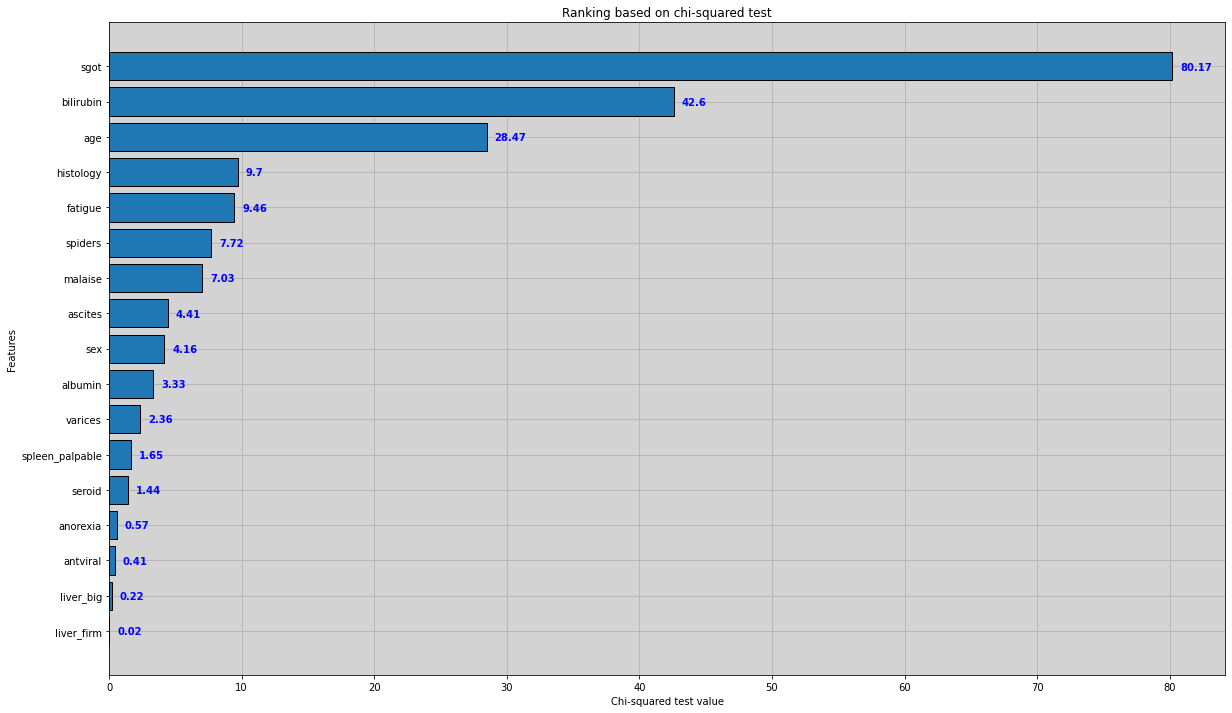

In [7]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)
estimator_num = len(chi2_scores['feature'])

# sort ascending because horizontal bars print in reverse order
ascending_features = chi2_scores.sort_values('score', ascending=True)

# create horizontal bar plot
plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')

# label bars and axis
plt.yticks(range(estimator_num), ascending_features['feature'])
plt.title('Ranking based on chi-squared test')
plt.ylabel('Features')
plt.xlabel('Chi-squared test value')

# add scores at bars end
for i, v in enumerate(ascending_features['score']):
    plt.text(v + 0.6, i - 0.1, str(v), color='blue', fontweight='bold')

# save to file must be call before show
plt.savefig(fname='ranking.png', orientation='landscape')
plt.show()

In [8]:
# chi2_support = chi2_selector.get_support()
# chi2_feature = X.loc[:,chi2_support].columns.tolist()
# print(chi2_feature)

In [9]:
# X_norm_striped = MinMaxScaler().fit_transform(X[chi2_feature])
# df = pd.DataFrame(data=X[chi2_feature], columns=chi2_feature)
# df.head()

# Experimental environment

### Classifiers declaration

In [10]:
clfs = {
    '512_momentum': MLPClassifier(hidden_layer_sizes=512, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '256_momentum': MLPClassifier(hidden_layer_sizes=256, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '128_momentum': MLPClassifier(hidden_layer_sizes=128, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '512_no_momentum': MLPClassifier(hidden_layer_sizes=512, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0),
    '256_no_momentum': MLPClassifier(hidden_layer_sizes=256, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0),
    '128_no_momentum': MLPClassifier(hidden_layer_sizes=128, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0)
}

In [11]:
n_splits = 2
n_repeats = 5
number_of_features = len(X.columns)
clfs_amount = len(clfs)

In [12]:
# result of every single k-fold 
f1_scores = np.zeros((len(clfs), number_of_features, n_splits * n_repeats))

### Model fitting with cross validation

In [13]:
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

In [14]:

for features_index in range(number_of_features):
    k_best_selector = SelectKBest(chi2, k=features_index + 1)
    selected_data = k_best_selector.fit_transform(X, y)

    for fold_id, (train_index, test_index) in enumerate(rskf.split(selected_data, y)):
        for clf_id, clf_name in enumerate(clfs):
            X_train, X_test = selected_data[train_index], selected_data[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf = clfs[clf_name]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            f1_scores[clf_id, features_index, fold_id] = f1_score(y_test, y_pred, average="binary")


on score: 0.625000
Iteration 13, loss = 0.55508731
Validation score: 0.625000
Iteration 14, loss = 0.59007094
Validation score: 0.750000
Iteration 15, loss = 0.60580139
Validation score: 0.750000
Iteration 16, loss = 0.56499555
Validation score: 0.750000
Iteration 17, loss = 0.51620659
Validation score: 0.750000
Iteration 18, loss = 0.49923119
Validation score: 0.750000
Iteration 19, loss = 0.50841977
Validation score: 0.750000
Iteration 20, loss = 0.52387474
Validation score: 0.750000
Iteration 21, loss = 0.53169772
Validation score: 0.750000
Iteration 22, loss = 0.52670537
Validation score: 0.750000
Iteration 23, loss = 0.51005171
Validation score: 0.750000
Iteration 24, loss = 0.48795760
Validation score: 0.750000
Iteration 25, loss = 0.47006920
Validation score: 0.750000
Validation score did not improve more than tol=0.000100 for 20 consecutive epochs. Stopping.
Iteration 1, loss = 1.93168860
Validation score: 0.625000
Iteration 2, loss = 0.65552411
Validation score: 0.750000
Itera

In [15]:
means = np.mean(f1_scores, axis=2)

In [16]:
print("=== Classifier, features, k-fold mean ===")
for clf_id, clf_name in enumerate(clfs):
    print(f"--- Classifier: {clf_name} ---")
    for feature_index in range(number_of_features):
        cls_mean = means[clf_id,feature_index]
        print("Features: %d, mean: %.4f" % (feature_index+1, cls_mean))

=== Classifier, features, k-fold mean ===
--- Classifier: 512_momentum ---
Features: 1, mean: 0.8849
Features: 2, mean: 0.8849
Features: 3, mean: 0.8547
Features: 4, mean: 0.8567
Features: 5, mean: 0.8344
Features: 6, mean: 0.8447
Features: 7, mean: 0.8849
Features: 8, mean: 0.8849
Features: 9, mean: 0.8694
Features: 10, mean: 0.8314
Features: 11, mean: 0.8713
Features: 12, mean: 0.8294
Features: 13, mean: 0.8628
Features: 14, mean: 0.8560
Features: 15, mean: 0.8605
Features: 16, mean: 0.8672
Features: 17, mean: 0.8597
--- Classifier: 256_momentum ---
Features: 1, mean: 0.8533
Features: 2, mean: 0.8834
Features: 3, mean: 0.8462
Features: 4, mean: 0.8664
Features: 5, mean: 0.8649
Features: 6, mean: 0.8089
Features: 7, mean: 0.8859
Features: 8, mean: 0.8646
Features: 9, mean: 0.8312
Features: 10, mean: 0.8849
Features: 11, mean: 0.8691
Features: 12, mean: 0.8644
Features: 13, mean: 0.8566
Features: 14, mean: 0.8399
Features: 15, mean: 0.8312
Features: 16, mean: 0.8324
Features: 17, mean:

In [17]:
means.shape

(6, 17)

## Plots

### Plots with momentum

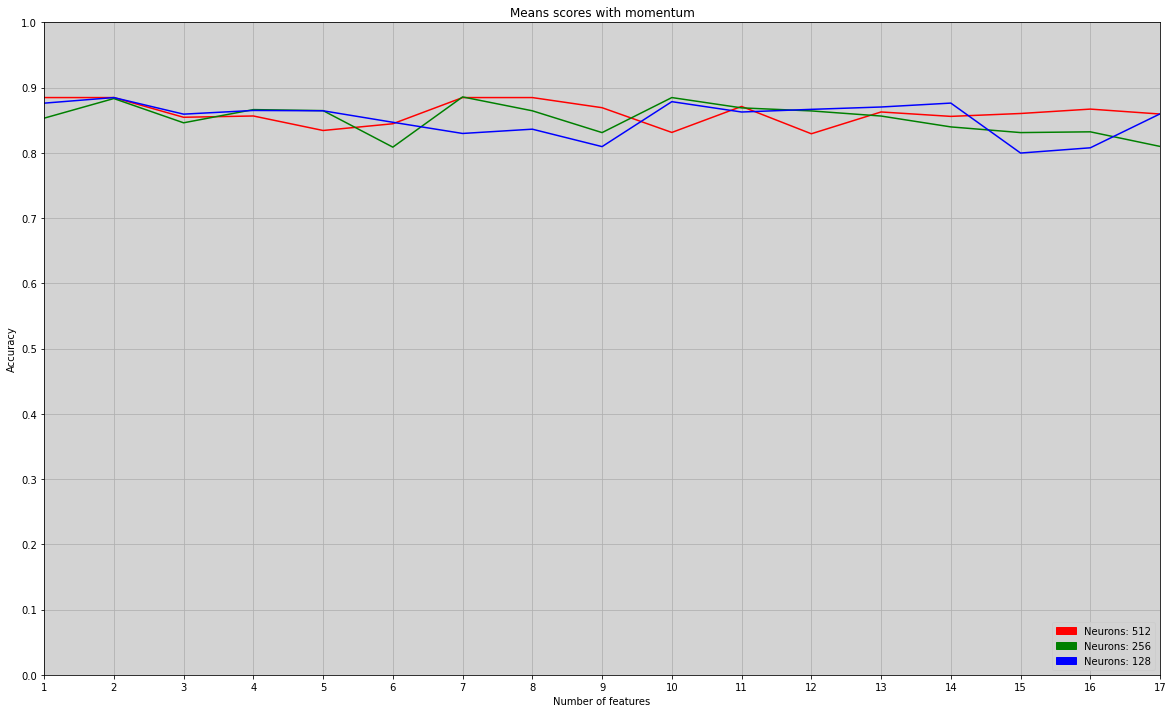

In [18]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)

plot_x = np.arange(1, number_of_features+1)
# create horizontal bar plot
# plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')
colors = ['red', 'green', 'blue']
for clf_id, clf_name in enumerate(clfs):
    if clf_id < 3: # only with momentum
        plt.plot(plot_x, means[clf_id], colors[clf_id])

# label bars and axis
axes = plt.gca()
axes.set_xlim([1,number_of_features])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(1, number_of_features+1, 1))
plt.title('Means scores with momentum')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

red_patch = mpatches.Patch(color='red', label='Neurons: 512')
green_patch = mpatches.Patch(color='green', label='Neurons: 256')
blue_patch = mpatches.Patch(color='blue', label='Neurons: 128')
legend_patches=[red_patch,green_patch,blue_patch]

# save to file must be call before show
plt.savefig(fname='means-with-momentum.png', orientation='landscape')
plt.legend(handles=legend_patches,loc=4)
plt.show()


### Plots without momentum

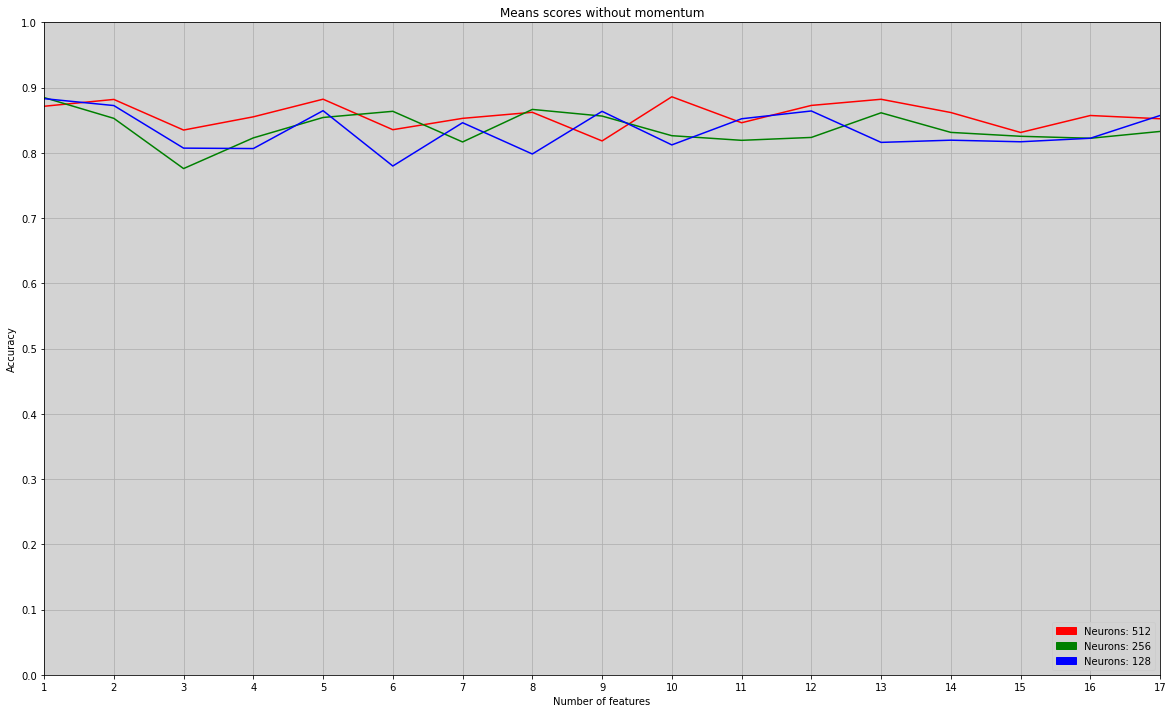

In [19]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)

plot_x = np.arange(1, number_of_features+1)
# create horizontal bar plot
# plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')
colors = ['red', 'green', 'blue']
for clf_id, clf_name in enumerate(clfs):
    if clf_id < 3: # only with no momentum
        plt.plot(plot_x, means[clf_id+3], colors[clf_id])

# label bars and axis
axes = plt.gca()
axes.set_xlim([1,number_of_features])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(1, number_of_features+1, 1))
plt.title('Means scores without momentum')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

red_patch = mpatches.Patch(color='red', label='Neurons: 512')
green_patch = mpatches.Patch(color='green', label='Neurons: 256')
blue_patch = mpatches.Patch(color='blue', label='Neurons: 128')
legend_patches=[red_patch,green_patch,blue_patch]

# save to file must be call before show
plt.savefig(fname='means-without-momentum.png', orientation='landscape')
plt.legend(handles=legend_patches,loc=4)
plt.show()

# Statistical analysis 

In [20]:
t_statistics = np.zeros((number_of_features, clfs_amount, clfs_amount))
p_values = np.zeros((number_of_features, clfs_amount, clfs_amount))

In [21]:

for feat in range(number_of_features): # we compare every classifier with each other for every feature number
    for cls_a in range(clfs_amount):
        for cls_b in range(clfs_amount):
            a = f1_scores[cls_a][feat]
            b = f1_scores[cls_b][feat]
            t_statistics[feat][cls_a][cls_b], p_values[feat][cls_a][cls_b] = ttest_ind(a, b)

In [22]:

t_statistics = np.round(t_statistics, 2)
p_values = np.round(p_values, 2)

for feat in range(number_of_features): 
    print(f"=== Number of features: {feat} ===")
    for clf_a_id, clf_a_name in enumerate(clfs):
        for clf_b_id, clf_b_name in enumerate(clfs):
            print(f'\tClassifier {clf_a_name} compare to {clf_b_name}:')
            print(f'\tstatistic = {t_statistics[feat][clf_a_id][clf_b_id]}, pvalue = {p_values[feat][clf_a_id][clf_b_id]}')
            print()



compare to 512_momentum:
	statistic = -1.74, pvalue = 0.1

	Classifier 256_no_momentum compare to 256_momentum:
	statistic = -1.64, pvalue = 0.12

	Classifier 256_no_momentum compare to 128_momentum:
	statistic = -1.41, pvalue = 0.18

	Classifier 256_no_momentum compare to 512_no_momentum:
	statistic = -0.79, pvalue = 0.44

	Classifier 256_no_momentum compare to 256_no_momentum:
	statistic = 0.0, pvalue = 1.0

	Classifier 256_no_momentum compare to 128_no_momentum:
	statistic = -0.99, pvalue = 0.33

	Classifier 128_no_momentum compare to 512_momentum:
	statistic = -0.94, pvalue = 0.36

	Classifier 128_no_momentum compare to 256_momentum:
	statistic = -0.8, pvalue = 0.43

	Classifier 128_no_momentum compare to 128_momentum:
	statistic = -0.48, pvalue = 0.64

	Classifier 128_no_momentum compare to 512_no_momentum:
	statistic = 0.23, pvalue = 0.82

	Classifier 128_no_momentum compare to 256_no_momentum:
	statistic = 0.99, pvalue = 0.33

	Classifier 128_no_momentum compare to 128_no_moment

### Display results

In [23]:
headers = [key for key in clfs.keys()]

for feat in range(0, number_of_features):
    print(f'=== T-test results for {feat+1} features ===')
    table_to_print = []
    one_row = []
    for clf_a_id, clf_a_name in enumerate(clfs):
        one_row.append(clf_name)
        for clf_b_id, clf_b_name in enumerate(clfs):
            tmp = 's: ' + str(t_statistics[feat][clf_a_id][clf_b_id]) + ', p: ' + str(p_values[feat][clf_a_id][clf_b_id])
            one_row.append(tmp)
        table_to_print.append(one_row)
        one_row = []
    print(tabulate(table_to_print, headers))
    print()


=== T-test results for 1 features ===
                 512_momentum       256_momentum      128_momentum       512_no_momentum    256_no_momentum    128_no_momentum
---------------  -----------------  ----------------  -----------------  -----------------  -----------------  -----------------
128_no_momentum  s: 0.0, p: 1.0     s: 1.0, p: 0.33   s: 1.01, p: 0.33   s: 1.24, p: 0.23   s: 0.0, p: 1.0     s: 0.93, p: 0.37
128_no_momentum  s: -1.0, p: 0.33   s: 0.0, p: 1.0    s: -0.7, p: 0.49   s: -0.55, p: 0.59  s: -1.0, p: 0.33   s: -0.94, p: 0.36
128_no_momentum  s: -1.01, p: 0.33  s: 0.7, p: 0.49   s: 0.0, p: 1.0     s: 0.35, p: 0.73   s: -1.01, p: 0.33  s: -0.8, p: 0.43
128_no_momentum  s: -1.24, p: 0.23  s: 0.55, p: 0.59  s: -0.35, p: 0.73  s: 0.0, p: 1.0     s: -1.24, p: 0.23  s: -1.07, p: 0.3
128_no_momentum  s: 0.0, p: 1.0     s: 1.0, p: 0.33   s: 1.01, p: 0.33   s: 1.24, p: 0.23   s: 0.0, p: 1.0     s: 0.93, p: 0.37
128_no_momentum  s: -0.93, p: 0.37  s: 0.94, p: 0.36  s: 0.8, p: 

In [24]:
# for clf_id, clf_name in enumerate(clfs):
#     print(f"--- Classifier: {clf_name} ---")
#     clf = clfs[clf_name]
#     y_pred = clf.predict(X)
#     tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
#     print("tn: {}, fp: {}, fn: {}, tp: {}".format(tn, fp, fn, tp))

--- Classifier: 512_momentum ---
tn: 16, fp: 16, fn: 47, tp: 76
--- Classifier: 256_momentum ---
tn: 9, fp: 23, fn: 11, tp: 112
--- Classifier: 128_momentum ---
tn: 0, fp: 32, fn: 0, tp: 123
--- Classifier: 512_no_momentum ---
tn: 4, fp: 28, fn: 16, tp: 107
--- Classifier: 256_no_momentum ---
tn: 0, fp: 32, fn: 0, tp: 123
--- Classifier: 128_no_momentum ---
tn: 0, fp: 32, fn: 0, tp: 123
